In [ ]:
import tensorflow as tf

# Ensure TensorFlow detects GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Set GPU as default device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.device('/GPU:0')
    print("Using GPU")
else:
    print("No GPU detected")


Num GPUs Available: 1
Using GPU


In [ ]:
tf.debugging.set_log_device_placement(True)


In [5]:
import numpy as np
import pandas as pd

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Instead of SMOTE or ADASYN, let's try a different oversampling method (e.g., SVM-SMOTE):
from imblearn.over_sampling import SVMSMOTE

# Load the dataset
df = pd.read_csv("/content/train_hsbc_df.csv")

# Define feature matrix X and target variable y
X = df.drop(columns=["fraud"])
y = df["fraud"]

# Convert 'age' column to numeric
X["age"] = pd.to_numeric(X["age"], errors='coerce')

# Convert 'gender' column to numeric (M -> 0, F -> 1)
X["gender"] = X["gender"].map({'M': 0, 'F': 1})

# Fill NaN values with 0
X = X.fillna(0)

# Select only numeric columns for scaling
numeric_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_cols])
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
!pip install -q cupy-cuda12x cuml-cu12 --extra-index-url=https://pypi.nvidia.com


In [9]:
!pip install -q cupy-cuda12x cudf-cu12 --extra-index-url=https://pypi.nvidia.com


In [10]:
import cupy as cp
import cudf
from imblearn.over_sampling import SMOTE

# Convert data to GPU-accelerated cuDF DataFrame
X_train_gpu = cudf.DataFrame(X_train)
y_train_gpu = cudf.Series(y_train)

# Apply SMOTE (CPU-based, but optimized with cuDF)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_gpu.to_pandas(), y_train_gpu.to_pandas())

# Convert back to GPU for faster TensorFlow training
X_train_resampled_gpu = cp.array(X_train_resampled.values)
y_train_resampled_gpu = cp.array(y_train_resampled.values)


In [11]:
# Build Neural Network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resampled, y_train_resampled,
          epochs=20, batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9132 - loss: 0.2493 - val_accuracy: 0.9592 - val_loss: 0.1922
Epoch 2/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9142 - loss: 0.2434 - val_accuracy: 0.9496 - val_loss: 0.1960
Epoch 3/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9148 - loss: 0.2421 - val_accuracy: 0.9564 - val_loss: 0.1948
Epoch 4/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9145 - loss: 0.2421 - val_accuracy: 0.9553 - val_loss: 0.1977
Epoch 5/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9150 - loss: 0.2408 - val_accuracy: 0.9575 - val_loss: 0.1898
Epoch 6/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9142 - loss: 0.2417 - val_accuracy: 0.9558 - val_loss: 0.1808
Epoch 7/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9145 - loss: 0.2409 - val_accuracy: 0.9540 - val_loss: 0.1946
Epoch 8/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 

In [13]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")


3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

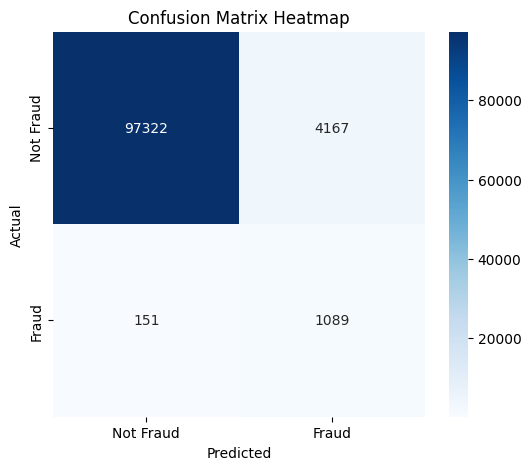

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [18]:
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    101489
           1       0.21      0.88      0.34      1240

    accuracy                           0.96    102729
   macro avg       0.60      0.92      0.66    102729
weighted avg       0.99      0.96      0.97    102729

